In [1]:
from ctypes import *
#ctypes.cdll.LoadLibrary('')
#lib1 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libsco.so")
#lib2 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libutils.so")

import sys
sys.path.append('deps/sparse_rrt')
sys.path.append('.')

from sparse_rrt.planners import SST
#from env.cartpole_obs import CartPoleObs
#from env.cartpole import CartPole
from sparse_rrt.systems.acrobot import Acrobot
from sparse_rrt.systems import standard_cpp_systems
from sparse_rrt import _sst_module
import numpy as np
import time
from tools.pcd_generation import rectangle_pcd
from plan_utility.line_line_cc import *
import pickle
obs_list = []
LENGTH = 20.
width = 6.
near = width * 1.2
# convert from obs to point cloud
# load generated point cloud
obs_list_total = []
obc_list_total = []
for i in range(2):
    file = open('data/acrobot_obs/obs_%d.pkl' % (i), 'rb')
    obs_list_total.append(pickle.load(file))
    file = open('data/acrobot_obs/obc_%d.pkl' % (i), 'rb')
    obc_list_total.append(pickle.load(file))

obs_idx = 0
p_idx =2
# Create custom system
#obs_list = [[-10., -3.],
#            [0., 3.],
#            [10, -3.]]
obs_list = obs_list_total[obs_idx]
obc_list = obc_list_total[obs_idx]
print('generated.')
print(obs_list.shape)

generated.
(4, 2)


In [2]:
# load path
path = open('data/acrobot_obs/%d/path_%d.pkl' % (obs_idx, p_idx), 'rb')
path = pickle.load(path)
controls = open('data/acrobot_obs/%d/control_%d.pkl' % (obs_idx, p_idx), 'rb')
controls = pickle.load(controls)

In [3]:
# visualize the path
"""
Given a list of states, render the environment
"""
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.patches as patches
from IPython.display import HTML
from visual.visualizer import Visualizer



class AcrobotVisualizer(Visualizer):
    def __init__(self, system, params):
        super(AcrobotVisualizer, self).__init__(system, params)
        self.dt = 0.05

    def _state_to_xy(self, state):
        angle0 = state[0]
        angle1 = state[1]
        x0 = 0.
        y0 = 0.
        x1 = LENGTH * np.cos(angle0 - np.pi/2)
        y1 = LENGTH * np.sin(angle0 - np.pi/2)
        x2 = x1 + LENGTH * np.cos(angle0 + angle1 - np.pi/2)
        y2 = y1 + LENGTH * np.sin(angle0 + angle1 - np.pi/2)
        return x0, y0, x1, y1, x2, y2
    def _init(self):
        # clear the current ax
        ax = plt.gca()
        ax.clear()
        # add patches
        state = self.states[0]
        print('state:')
        print(state)
        x0, y0, x1, y1, x2, y2 = self._state_to_xy(state)
        print('x1: %f, y1: %f, x2: %f, y2: %f' % (x1, y1, x2, y2))
        self.l1 = ax.plot([x0,x1,x2], [y0,y1,y2])[0]
        self.recs = []
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor='black',facecolor='black')
            self.recs.append(obs)
            ax.add_patch(obs)
        self.recs.append(self.l1)
        return self.recs
    def _animate(self, i):
        ax = plt.gca()
        ax.set_xlim(-40, 40)
        ax.set_ylim(-40, 40)
        state = self.states[i]
        x0, y0, x1, y1, x2, y2 = self._state_to_xy(state)
        self.l1.set_xdata([x0,x1,x2])
        self.l1.set_ydata([y0,y1,y2])
        return self.recs


 
    def animate(self, states, actions, obstacles):
        '''
        given a list of states, actions and obstacles, animate the robot
        '''
        # transform the waypoint states and actions into trajectory
        traj = []
        for i in range(len(states)-1):
            print('state: %d, remaining: %d' % (i, len(states)-i))
            s = states[i]
            print(s)
            action = actions[i]
            sT = states[i+1]
            # propogate until reaching next state
            while True:
                traj.append(np.array(s))
                #print("porpagating...")
                #print(s)
                #print('st:')
                #print(sT)
                #print('distance:')
                #print(np.linalg.norm(s-sT))
                s = self.system.propagate(s, action, 1, self.params['integration_step'])
                if np.linalg.norm(s-sT) <= 0.1:
                    break
        traj = np.array(traj)
        print(traj)
        print("animating...")
        # animate
        self.states = traj
        self.obs = obstacles
        print(len(self.states))
        ani = animation.FuncAnimation(plt.gcf(), self._animate, range(0, len(self.states)),
                                      interval=self.dt*500, blit=True, init_func=self._init,
                                      repeat=True)
        return ani


states:
[[ 0.          0.          0.          0.        ]
 [ 0.24618453 -0.5358435   1.08646313 -2.47822479]
 [-0.4639669   0.65749695 -2.32948758  4.69288885]
 [-0.95053827  2.02606258  0.25059166  1.93537181]
 [ 0.25039073  1.32602158  3.19492212 -4.32776614]
 [ 0.9840746  -2.24552697 -3.88743764 -0.12124375]
 [ 0.0600017  -1.99107685 -5.09317184  2.83881588]
 [-0.62561986 -1.52598716 -4.46163354  3.74223756]
 [ 1.94978757  1.95875835  2.92651529 -3.5374446 ]
 [ 2.20375631  1.63971243  1.99345356 -2.64930451]
 [ 2.48238639  1.24503522  0.46895999 -0.75852185]]
state: 0, remaining: 11
[0. 0. 0. 0.]
state: 1, remaining: 10
[ 0.24618453 -0.5358435   1.08646313 -2.47822479]
state: 2, remaining: 9
[-0.4639669   0.65749695 -2.32948758  4.69288885]
state: 3, remaining: 8
[-0.95053827  2.02606258  0.25059166  1.93537181]
state: 4, remaining: 7
[ 0.25039073  1.32602158  3.19492212 -4.32776614]
state: 5, remaining: 6
[ 0.9840746  -2.24552697 -3.88743764 -0.12124375]
state: 6, remaining: 5
[ 0

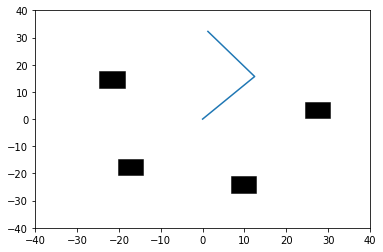

In [4]:
params = {}
params['obs_w'] = width
params['obs_h'] = width
params['integration_step'] = 0.02
system = Acrobot()
vis = AcrobotVisualizer(system, params)
states = path
actions = controls
print('states:')
print(states)
anim = vis.animate(np.array(states), np.array(actions), obs_list)
HTML(anim.to_html5_video())
#anim.save('acrobot_env%d_path%d.mp4' % (obs_idx, p_idx))

(4, 1400, 2)
(5600, 2)


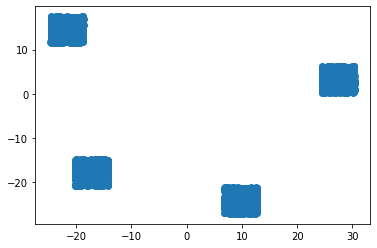

In [5]:
# visualize point cloud
import matplotlib.pyplot as plt
print(obc_list.shape)
obc_all = np.concatenate(obc_list_total[obs_idx], axis=0)
print(obc_all.shape)
plt.scatter(obc_all[:,0], obc_all[:,1])
plt.show()

(5600, 2)


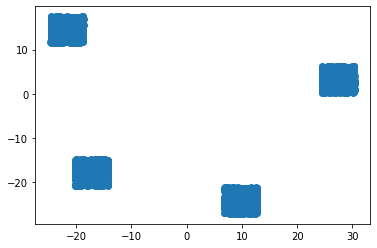

(5600, 2)


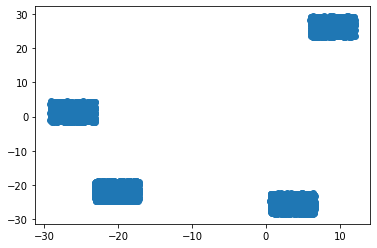

In [6]:
for i in range(2):
    obc_all = np.concatenate(obc_list_total[i], axis=0)
    print(obc_all.shape)
    plt.scatter(obc_all[:,0], obc_all[:,1])
    plt.show()